<h2 style="text-align: center; font-weight: bold;">Text Mining and Natural Language Processing</h2>



<div style="text-align: center;">
  <img src="https://bse.eu/sites/default/files/bse_logo_small.png" alt="bse_logo_textminingcourse">
</div>


# **Homework 2: Mini Research Project**

## Authors: 
    -Alejandro Vacca
    -Simon Vellin
    -Matias Borrell

# Part 1: Getting The Data

## Project imports

In [77]:
# Text Processing Libraries
import re  # Regular expressions
import nltk  # Natural Language Toolkit
import spacy  # Advanced NLP processing


# Stemming and Lemmatization
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer

# Tokenization and Stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Machine Learning & Feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score

import numpy as np

# Visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud

#Dateframes and file reading
import pandas as pd
import os
from tqdm.notebook import tqdm
tqdm.pandas()
from collections import Counter

import seaborn as sns



# Download necessary NLTK resources (if not already downloaded)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)


True

## 1.1 Dataset Overview: Mental Health Corpus

The **Mental Health Corpus** is a dataset containing texts related to *anxiety, depression*, and other mental health issues. It includes user comments labeled as either **poisonous** or **not**, making it useful for **sentiment analysis, toxic language detection**, and **mental health research**.

*(Mental Health Corpus, n.d.). Retrieved from Kaggle:*  
[🔗 Mental Health Corpus on Kaggle](https://www.kaggle.com/datasets/reihanenamdari/mental-health-corpus)

### Dataset Information
The data is stored in a file named `mental_health.csv` and consists of the following columns:

| Column Name | Description |
|-------------|------------|
| `text`  | User-generated comments |
| `label` | Binary classification: **1** means a comment is considered poisonous related to mental health issues, and **0** means it is not. |


In [78]:
csv_directory = os.path.join(os.getcwd(), "files", "general_results")
df = pd.read_csv("data/mental_health.csv")
df.head()


,text,label
0,dear american teens question dutch person hear...,0
1,nothing look forward lifei dont many reasons k...,1
2,music recommendations im looking expand playli...,0
3,im done trying feel betterthe reason im still ...,1
4,worried year old girl subject domestic physic...,1


We observe that our **DataFrame** contains **27,977 rows**, with each row corresponding to a **unique comment**.

🔍 **Observations:**
-  We confirm that there are **no null or missing values** in the dataset.
-  The distribution of labels is around **50%**, meaning we are dealing with a **balanced dataset**.

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27977 entries, 0 to 27976
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    27977 non-null  object
 1   label   27977 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 437.3+ KB


In [80]:
# Count of Labels with the value 0  / Total count of Labels.
len(df[df['label']==0]) / len(df['label'])

0.5053794188083068

## 1.2 Data Pre-processing:

### **Text Preprocessing Setup**

We define several preprocessing functions to **clean and transform text** for **Natural Language Processing (NLP)** tasks.

🔧 **Initialization of Key Variables:**
-  **`sp`** → Pre-trained **spaCy model** (`en_core_web_sm`) for **lemmatization**.
-  **`porter`** → **SnowballStemmer** (from `nltk`) for **stemming**.
-  **`lmtzr`** → **WordNetLemmatizer** (from `nltk`) for **lemmatization**.
-  **`custom_stopwords`** → Custom dictionary with a list of **stop-words** selected based on testing. 

In [81]:
# Load spaCy model
sp = spacy.load("en_core_web_sm")

# Load previous preprocessing functions
porter=SnowballStemmer("english")
lmtzr = WordNetLemmatizer()

STOP_WORDS = set(stopwords.words('english'))

# Custom stop words related to mental health
custom_stopwords = {'s', 'br', 'see', 'even', 'im', 'ive', 'na'}
STOP_WORDS.update(custom_stopwords)



#### 🔹 **Visualization: Word Clouds (`df, text_column`)**

In [82]:
# Define a function to generate word clouds for each class
def generate_wordclouds(df, text_column, stopwords=None):
    label_corpus = {}
    
    
    # Iterate through each unique class in the dataset
    for label in df['label'].unique():
        # Filter descriptions by label
        text_corpus = " ".join(df[df['label'] == label][text_column].dropna())
        
        # Store the processed text in the dictionary
        label_corpus[label] = text_corpus
    
    # Generate and display word clouds side by side
    num_label = len(label_corpus)
    fig, axes = plt.subplots(1, num_label, figsize=(10 * num_label, 5))
    
    if num_label == 1:
        axes = [axes]  # Ensure axes is iterable if there's only one class
    
    for ax, (label, text) in zip(axes, label_corpus.items()):
        if text.strip():  # Ensure the text is not empty
            wordcloud = WordCloud(
                width=800, 
                height=400, 
                background_color='white', 
                colormap='viridis', 
                max_words=100,
                stopwords=custom_stopwords
            ).generate(text)
            
            # Display the word cloud
            ax.imshow(wordcloud, interpolation="bilinear")
            ax.axis("off")  # Remove axes
            ax.set_title(f"Word Cloud for {label}")
    
    plt.show()


#### 🔹 **Lowercasing & Stopword Removal (`preprocess_lower`)**
- Converts text to **lowercase**.
- **Removes punctuation** and tokenizes words.
- **Filters out stopwords** (default + custom mental health-related stopwords).


In [83]:

def preprocess_lower(text):
    
    # Lowercase the text
    text_lower = text.lower()

    # Remove punctuation (everything except word characters and whitespace)
    text_no_punct = re.sub(r'[^\w\s]', '', text_lower)

    # Tokenize the cleaned text.
    tokens = word_tokenize(text_no_punct)

    # Filter out stopwords.
    filtered_tokens = [token for token in tokens if token not in STOP_WORDS]

    return " ".join(filtered_tokens)



#### 🔹 **Stemming (`preprocess_stem`)**
- Applies **stemming** using the **Porter Stemmer**.
- Uses preprocessed text from `preprocess_lower` and reduces words to their root forms.


In [84]:


def preprocess_stem(text):

    # Get the cleaned lowercased and stopwords-removed tokens.
    joined_tokens = preprocess_lower(text)
    
    tokens=word_tokenize(joined_tokens)

    # Initialize the Porter Stemmer.
    ps = PorterStemmer()

    # Stem each token.
    stemmed_tokens = [ps.stem(token) for token in tokens]

    return " ".join(stemmed_tokens)



#### 🔹 **Lemmatization (`preprocess_lemma`)**
- Uses **spaCy** to extract the **lemma** of each token.
- Removes **stopwords and punctuation** for cleaner text.
- **No Lowercasing applied.**


In [85]:
def preprocess_lemma(text):

    # Process text using spaCy
    doc = sp(text)

    # Extract the lemma of each token, filtering out tokens flagged as punctuation or stopwords.
    lemmatized_tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and token.lemma_.strip() != '']

    return " ".join(lemmatized_tokens)



#### 🔹 **Tokenization (`tokenize`)**
- A flexible function to apply **lowercasing (mode 0), stemming (mode 1), or lemmatization (mode 2)**.
- Raises an error for invalid mode selections.

In [86]:
def tokenize(text, mode=0):

    if mode == 0:
        return preprocess_lower(text)
    elif mode == 1:
        return preprocess_stem(text)
    elif mode == 2:
        return preprocess_lemma(text)
    else:
        raise ValueError("Invalid mode. Please use 0 for lowercasing, 1 for stemming, or 2 for lemmatizing.")

### **Applying Preprocessing Functions**

Now, we apply our **text preprocessing functions** to the main corpus and create **new columns** in our DataFrame for comparison purposes.

In [87]:
df['text_no_stopwords']= df['text'].progress_apply(lambda x: preprocess_lower(x) if pd.notna(x) else "")
df['text_stem']= df['text_no_stopwords'].progress_apply(lambda x: preprocess_stem(x) if pd.notna(x) else "")
df['text_lemma']= df['text_no_stopwords'].progress_apply(lambda x: preprocess_lemma(x) if pd.notna(x) else "")
df

  0%|          | 0/27977 [00:00<?, ?it/s]

  0%|          | 0/27977 [00:00<?, ?it/s]

  0%|          | 0/27977 [00:00<?, ?it/s]

,text,label,text_no_stopwords,text_stem,text_lemma
0,dear american teens question dutch person hear...,0,dear american teens question dutch person hear...,dear american teen question dutch person heard...,dear american teen question dutch person hear ...
1,nothing look forward lifei dont many reasons k...,1,nothing look forward lifei dont many reasons k...,noth look forward lifei dont mani reason keep ...,look forward lifei not reason going feel like ...
2,music recommendations im looking expand playli...,0,music recommendations looking expand playlist ...,music recommend look expand playlist usual gen...,music recommendation look expand playlist usua...
3,im done trying feel betterthe reason im still ...,1,done trying feel betterthe reason still alive ...,done tri feel betterth reason still aliv know ...,try feel betterthe reason alive know mum devas...
4,worried year old girl subject domestic physic...,1,worried year old girl subject domestic physica...,worri year old girl subject domest physicalmen...,worry year old girl subject domestic physicalm...
...,...,...,...,...,...
27972,posting everyday people stop caring religion ...,0,posting everyday people stop caring religion m...,post everyday peopl stop care religion matter ...,post everyday people stop care religion matter...
27973,okay definetly need hear guys opinion ive pret...,0,okay definetly need hear guys opinion pretty m...,okay definetli need hear guy opinion pretti mu...,okay definetly need hear guy opinion pretty lo...
27974,cant get dog think ill kill myselfthe last thi...,1,cant get dog think ill kill myselfthe last thi...,cant get dog think ill kill myselfth last thin...,not dog think ill kill myselfthe thing hold yu...
27975,whats point princess bridei really think like ...,1,whats point princess bridei really think like ...,what point princess bridei realli think like w...,s point princess bridei think like wesley say ...


### 🔄 **Iterative Stopword Refinement Process**

We **visualize word frequency** after **removing standard stopwords**. This allows us to identify **high-frequency words** that are **topic-general** but **not relevant** to our analysis.


1. **Visualize word counts** to detect common, non-informative words.
2. **Identify problematic words** that still appear frequently but add little value.
3. **Add these words to `custom_stopwords`** to refine the dataset.
4. **Repeat the process** until we filter out unnecessary words.


This step ensures that our final **lemmatized dataset** captures the most **meaningful words** for analysis. 


In [88]:
# Flatten all words from the 'text_no_stopwords' column into a single list
all_words = " ".join(df['text_no_stopwords'].dropna()).split()

# Count occurrences of each word
word_frequencies = Counter(all_words)


# Convert to DataFrame for better visualization
word_freq_df = pd.DataFrame(word_frequencies.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)

word_freq_df.head(30)


,Word,Frequency
18,like,22300
35,want,17299
96,know,15475
30,feel,14508
105,life,14386
8,get,13094
210,one,12405
53,people,11249
316,would,11001
207,time,10829


###  **Results Visualization**

####  ☁ Word Cloud Interpretation:
-   **Word Cloud for `label = 0`** → Displays **neutral or non-negative** mental health-related words.
-  **Word Cloud for `label = 1`** → Represents words related to **mental distress, anxiety, and depression**.

These visualizations help us **understand the dominant themes** in each category and analyze the distribution of words in the dataset.


*World Cloud Before Pre-Processing*

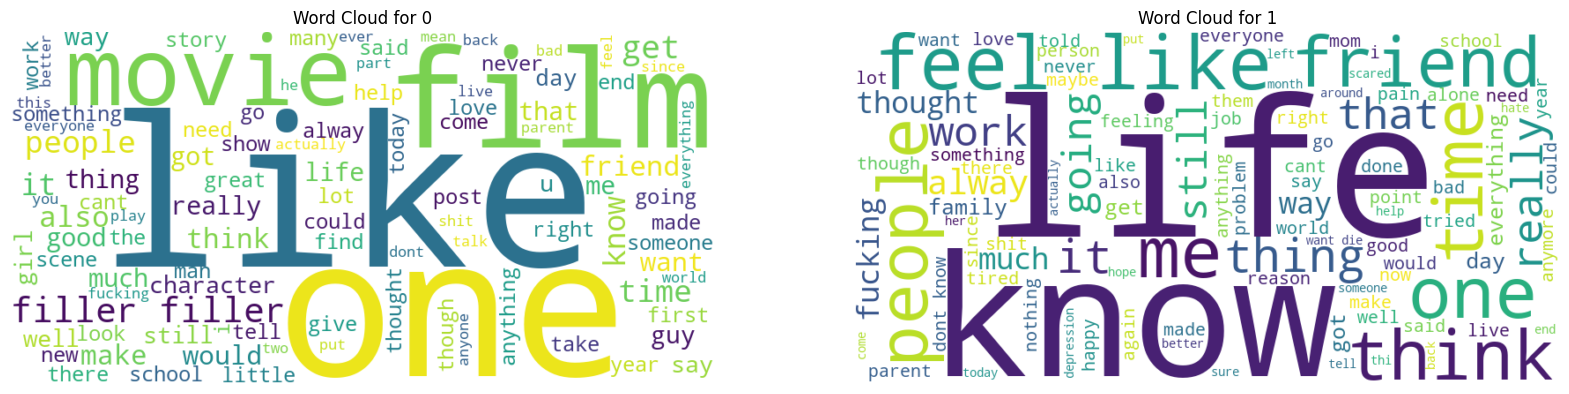

In [89]:
generate_wordclouds(df, 'text')

*World Cloud after Pre-processing*

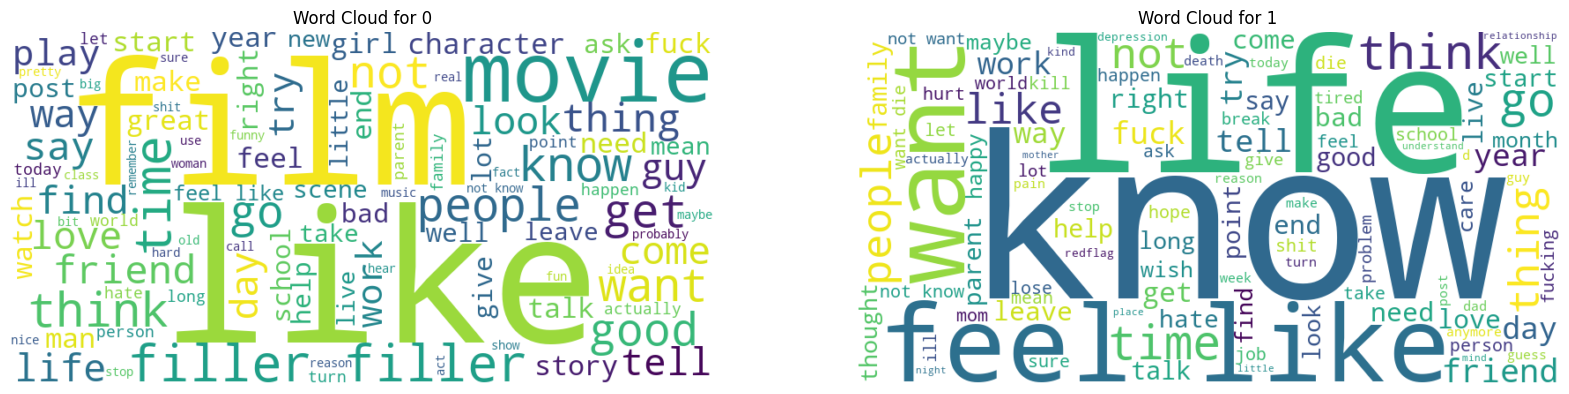

In [90]:
generate_wordclouds(df, 'text_lemma', stopwords=custom_stopwords)

### Checkpoint 1: Pre-Process

The preprocessed text is saved in a CSV file for subsequent steps.  This is necessary because the preprocessing itself requires approximately 10 minutes.

In [91]:
df.to_csv("data/preprocessing/mental_health_preprocessed.csv")

---

# Part 2: Analysis TF-IDF, LDA.

### **2.1 Splitting the Main Corpus**

We will divide the **Mental Health Corpus** (`mental_health.csv`) into two distinct **Sub-Corpus** based on the **binary classification (`label`)**:

- **`df_filtered_0`** → Contains only comments labeled as **`0`**, meaning they are **non-related** to mental health issues.
- **`df_filtered_1`** → Contains only comments labeled as **`1`**, meaning they are **toxic or distressing**.

This separation allows for a more targeted analysis of both **neutral** and **mental health-related** texts.


In [92]:
df = pd.read_csv("data/preprocessing/mental_health_preprocessed.csv")

In [93]:
df_filtered_0 = df[df["label"] == 0]  # Extract all rows where label == 0 (Non-Toxic)
df_filtered_1 = df[df["label"] == 1]  # Extract all rows where label == 1 (Toxic)

Isolating the text to make it usefull for **TF-IDF**

In [94]:
# Separate texts based on label
texts_0 = df[df["label"] == 0]["text_lemma"].dropna().tolist()  # Healthy group
texts_1 = df[df["label"] == 1]["text_lemma"].dropna().tolist()  # Mentally ill group

### **2.2 Method Set up:**
- **max_features:** Displaying only the **top 30 words** to maintain clear visualization.
- **Cosine Similarity (`norm='l2'`):**  
  - Used to **normalize text length**, ensuring that comment size differences **do not distort feature importance**.
- **Smoothing:** Applied to **prevent division by zero** and stabilize TF-IDF scores.
- **Document Frequency Thresholds:**  
  - **`max_df = 1.0`** → No words are ignored based on document frequency.  
  - **`min_df = 1`** → Words must appear in **at least one document** to be considered.  
  - These values serve as **baseline thresholds**, which we will **adjust iteratively**.
    

In [95]:
# Apply TF-IDF separately for each group
vectorizer_0 = TfidfVectorizer(stop_words='english', max_df=1.0, min_df=1, max_features=30 , norm="l2")
tfidf_0 = vectorizer_0.fit_transform(texts_0)
words_0 = vectorizer_0.get_feature_names_out()
scores_0 = np.asarray(tfidf_0.mean(axis=0)).flatten()

vectorizer_1 = TfidfVectorizer(stop_words='english', max_df=1.0, min_df=1, max_features=30 , norm="l2")
tfidf_1 = vectorizer_1.fit_transform(texts_1)
words_1 = vectorizer_1.get_feature_names_out()
scores_1 = np.asarray(tfidf_1.mean(axis=0)).flatten()

# Create DataFrames with extracted words and scores
df_tfidf_0 = pd.DataFrame({"word": words_0, "score": scores_0}).sort_values(by="score", ascending=False)
df_tfidf_1 = pd.DataFrame({"word": words_1, "score": scores_1}).sort_values(by="score", ascending=False)

In [96]:
df_tfidf_0

,word,score
12,like,0.120705
10,know,0.073843
26,want,0.070881
7,good,0.065869
16,people,0.061671
25,time,0.059143
24,think,0.058959
4,film,0.058452
15,movie,0.057779
1,day,0.055548


In [97]:
df_tfidf_1

,word,score
26,want,0.162519
6,feel,0.155653
15,like,0.132723
13,know,0.130228
14,life,0.124016
23,think,0.101026
24,time,0.093772
19,people,0.087452
25,try,0.086977
29,year,0.085796


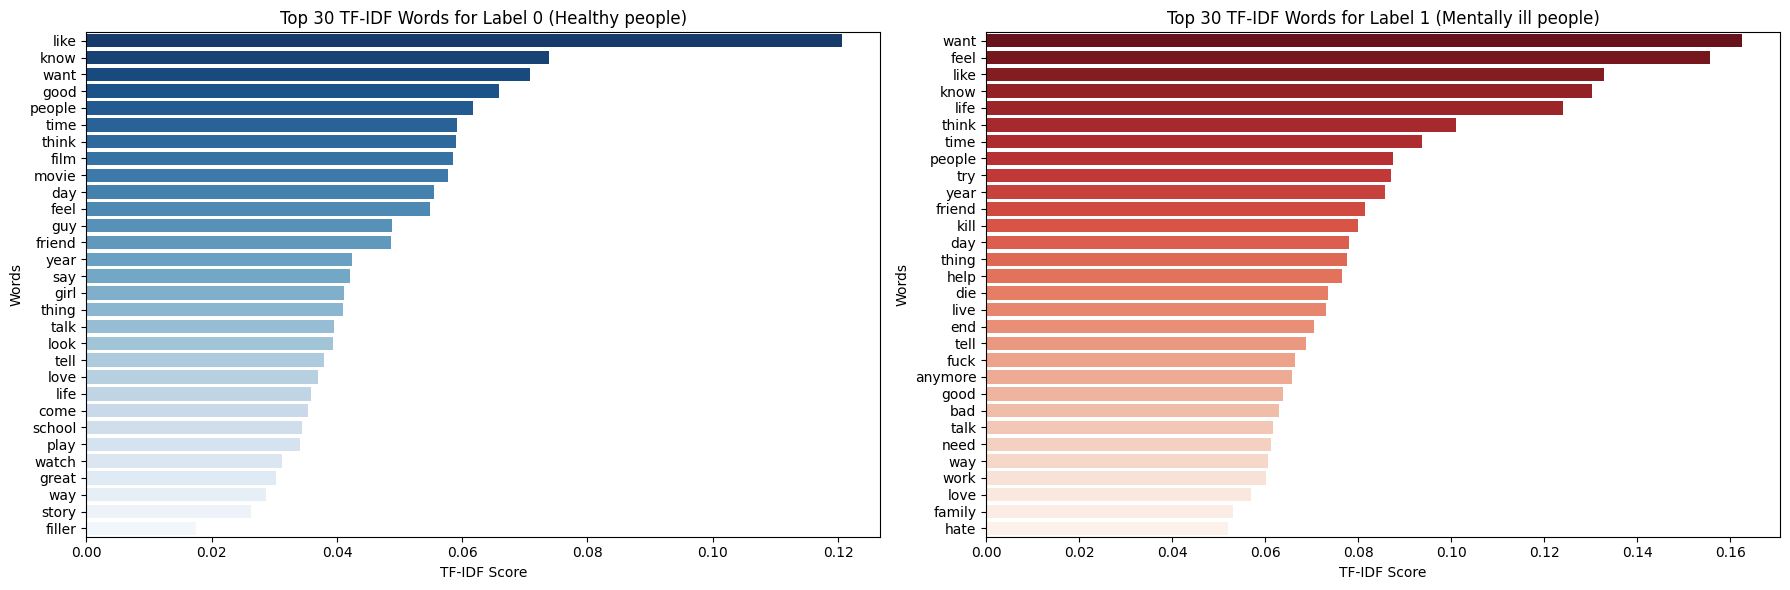

In [98]:
# Plot TF-IDF scores for both labels side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.barplot(y=df_tfidf_0["word"], x=df_tfidf_0["score"], hue=df_tfidf_0["word"], dodge=False, palette="Blues_r", ax=axes[0])
axes[0].set_title("Top 30 TF-IDF Words for Label 0 (Healthy people)")
axes[0].set_xlabel("TF-IDF Score")
axes[0].set_ylabel("Words")


sns.barplot(y=df_tfidf_1["word"], x=df_tfidf_1["score"], hue=df_tfidf_1["word"], dodge=False, palette="Reds_r", ax=axes[1])
axes[1].set_title("Top 30 TF-IDF Words for Label 1 (Mentally ill people)")
axes[1].set_xlabel("TF-IDF Score")
axes[1].set_ylabel("Words")

plt.tight_layout()
plt.show()

### **2.3 Refining the Word Scoring Approach**

Upon analyzing the results, we observe that **some of the top-ranked words** are still **shared by both dictionaries**. This overlap reduces their effectiveness in distinguishing between the categories.

To address this issue, we will:
**Modify the TF-IDF scoring mechanism** to **downweight shared words** that appear in both dictionaries.

For that purpose we will do the folowwing:

$$\textbf{Adjusted Score} = \frac{\text{TF-IDF en mentally ill}}{\text{TF-IDF en healthy} + \epsilon}$$

We consider them more appropiated than **Refine document frequency thresholds (`max_df` and `min_df`)** due that we wont loose relevant information with a high count of Corpus frecuency.



In [99]:
# Extract dictionary from each corpus using TF-IDF
dictionary_0 = set(df_tfidf_0["word"])  # Healthy words
dictionary_1 = set(df_tfidf_1["word"])  # Mentally ill words

In [100]:
# Calculate frequency of words in both classes
word_weights = {}
for word in dictionary_1:
    freq_1 = df_tfidf_1[df_tfidf_1["word"] == word]["score"].values[0] if word in df_tfidf_1["word"].values else 0
    freq_0 = df_tfidf_0[df_tfidf_0["word"] == word]["score"].values[0] if word in df_tfidf_0["word"].values else 0
    word_weights[word] = freq_1 / (freq_0 + 1e-6)  # Avoid division by zero

# Sort words by importance (higher values = more relevant to mentally ill class)
filtered_words = sorted(word_weights.items(), key=lambda x: x[1], reverse=True)[:30]  # Keep top 30 words

print("Mentally ill dictionary generated.")


df_filtered_words = pd.DataFrame(filtered_words, columns=["word", "score"])
df_filtered_words

Mentally ill dictionary generated.


,word,score
0,try,86976.602418
1,kill,79844.248438
2,help,76576.595099
3,die,73461.700227
4,live,73055.696070
5,end,70422.822110
6,fuck,66437.175143
7,anymore,65741.747711
8,bad,62946.226755
9,need,61135.726906


### **2.3.1 Adjusted Scoring Visualization:**

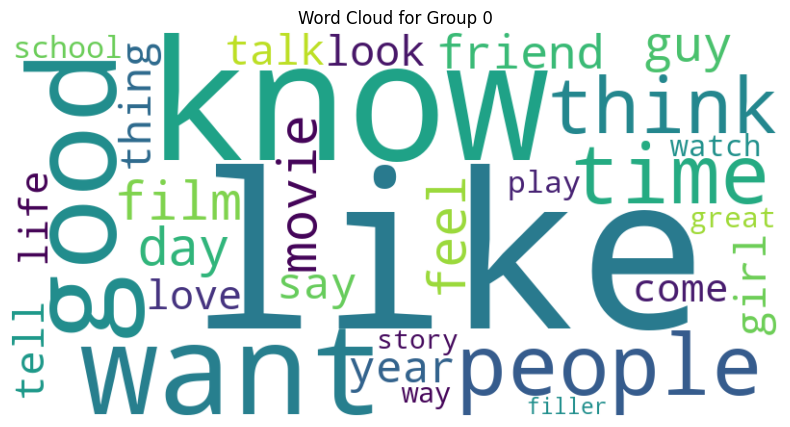

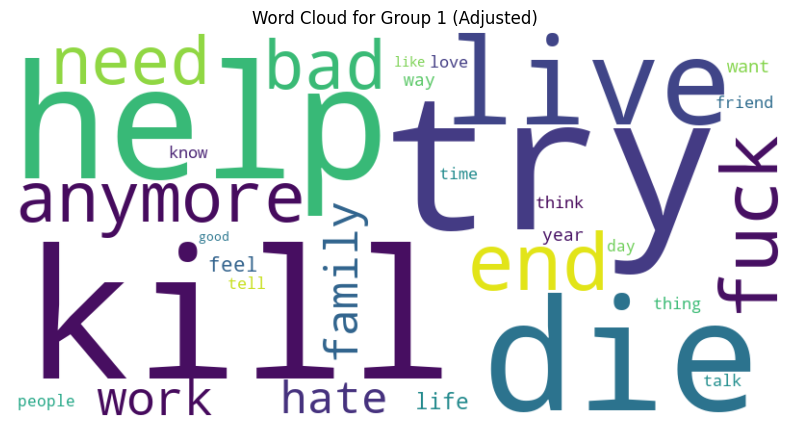

In [101]:
# Function to generate and display word cloud
def generate_wordcloud(df_tfidf, title, column_1, column_2):
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(
        dict(zip(df_tfidf[column_1], df_tfidf[column_2]))
    )

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

# Generate word clouds for both groups
generate_wordcloud(df_tfidf_0, "Word Cloud for Group 0", column_1='word', column_2='score')
generate_wordcloud(df_filtered_words, "Word Cloud for Group 1 (Adjusted)", column_1='word', column_2='score')

### **2.4 Analysis n-GRAMS:**

In [102]:
# Process n-grams separately for each class
# Label 0 (Healthy people)
vectorizer_ngrams_0 = CountVectorizer(ngram_range=(2, 3), max_features=10000)  # Limit feature size
X_ngrams_0 = vectorizer_ngrams_0.fit_transform(texts_0)
ngrams_counts_0 = X_ngrams_0.sum(axis=0).A1
ngrams_counts_df_0 = pd.DataFrame({'ngram': vectorizer_ngrams_0.get_feature_names_out(), 'count': ngrams_counts_0}).sort_values(by='count', ascending=False)

# Label 1 (Mentally ill people)
vectorizer_ngrams_1 = CountVectorizer(ngram_range=(2, 3), max_features=10000)  # Limit feature size
X_ngrams_1 = vectorizer_ngrams_1.fit_transform(texts_1)
ngrams_counts_1 = X_ngrams_1.sum(axis=0).A1
ngrams_counts_df_1 = pd.DataFrame({'ngram': vectorizer_ngrams_1.get_feature_names_out(), 'count': ngrams_counts_1}).sort_values(by='count', ascending=False)

ngrams_counts_df_1.head(20)

,ngram,count
1971,feel like,6193
5971,not know,1736
9136,want die,1575
6128,not want,1462
9920,year old,978
3008,good friend,853
9843,year ago,755
9242,want kill,752
7861,suicidal thought,694
9265,want live,668


### **2.5 Toppic Generation using LDA**



**Latent Dirichlet Allocation (LDA)** is a widely used technique in **Natural Language Processing (NLP)** for **topic modeling**, allowing us to uncover **hidden topics** within a collection of documents.

- LDA assumes that **each document** is a **mixture of multiple topics**.
- Each **topic** is represented as a **distribution over words**.
- The algorithm **infers these hidden topics** by analyzing word occurrences across documents.


The **topic clusters** for the **Mentally Ill People** category reveal dominant themes of **emotional distress**, **hopelessness**, and **mental struggles**. 

#### **2.5.1 Observations from Word Topic Clusters**
- **Suicidal ideation & despair** → Words like *"want"*, *"die"*, *"kill"*, and *"life"* appear frequently, indicating thoughts of self-harm and crisis.
- **Emotional suffering & pain** → Terms such as *"feel"*, *"pain"*, and *"help"* reflect inner turmoil and a struggle for support.
- **Isolation & hopelessness** → Words like *"friend"*, *"family"*, and *"school"* suggest a longing for connection, yet possible detachment.
- **Repetitive distress patterns** → Recurring words (*"think"*, *"know"*, *"try"*) highlight mental loops, uncertainty, and self-doubt.




In [103]:
# Apply LDA separately for each group
vectorizer_0_lda = CountVectorizer(stop_words="english", max_features=1000)
X_0 = vectorizer_0_lda.fit_transform(texts_0)

vectorizer_1_lda = CountVectorizer(stop_words="english", max_features=1000)
X_1 = vectorizer_1_lda.fit_transform(texts_1)

num_topics = 5
lda_model_0 = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model_0.fit(X_0)

lda_model_1 = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model_1.fit(X_1)

# Extract topic words
words_0_lda = vectorizer_0_lda.get_feature_names_out()
words_1_lda = vectorizer_1_lda.get_feature_names_out()

topics_0 = {}
topics_1 = {}

for topic_idx, topic in enumerate(lda_model_0.components_):
    top_words = [words_0_lda[i] for i in topic.argsort()[:-11:-1]]
    topics_0[f"Topic {topic_idx+1}"] = top_words

for topic_idx, topic in enumerate(lda_model_1.components_):
    top_words = [words_1_lda[i] for i in topic.argsort()[:-11:-1]]
    topics_1[f"Topic {topic_idx+1}"] = top_words

# Convert topics to DataFrame
df_topics_0 = pd.DataFrame(topics_0)
df_topics_1 = pd.DataFrame(topics_1)

# Display results
print("Topics for Label 0 (Healthy people):")
print(df_topics_0)

print("\nTopics for Label 1 (Mentally ill people):")
print(df_topics_1)

Topics for Label 0 (Healthy people):
  Topic 1 Topic 2  Topic 3    Topic 4 Topic 5
0    like     man   filler       film    like
1     day    like    quick      movie    talk
2    feel     say     jump       good    girl
3    know    time    brown       like    know
4    want    look     lazy  character  friend
5    fuck   sleep  gtpoplt      great     guy
6  people    come    horny      story  people
7  friend    hour      pee       time    want
8    time   night      poo      watch  school
9    year    girl     bruh       love    post

Topics for Label 1 (Mentally ill people):
  Topic 1 Topic 2  Topic 3 Topic 4 Topic 5
0    want    feel     help    year    want
1    know    like     feel    life    life
2     day    know     know    work    like
3    feel    tell  redflag     job    feel
4     die  friend     like  school  people
5   think    want     want    time    fuck
6   sleep    time    think  friend    know
7    pain   think     need     try    hate
8    time    love      try 

#### **2.5.2 Observations from n-Grams Topic Clusters**

The extracted **n-grams** (word sequences) reveal deeper patterns of **emotional distress, suicidal ideation, and psychological struggles**.

Supporting our previous result with only words analysis.


In [104]:
# Process n-grams separately for each class
# Label 0 (Healthy people)
vectorizer_ngrams_0 = CountVectorizer(ngram_range=(2, 3), max_features=10000)  # Limit feature size
X_ngrams_0 = vectorizer_ngrams_0.fit_transform(texts_0)
ngrams_counts_0 = X_ngrams_0.sum(axis=0).A1
ngrams_counts_df_0 = pd.DataFrame({'ngram': vectorizer_ngrams_0.get_feature_names_out(), 'count': ngrams_counts_0}).sort_values(by='count', ascending=False)

# Label 1 (Mentally ill people)
vectorizer_ngrams_1 = CountVectorizer(ngram_range=(2, 3), max_features=10000)  # Limit feature size
X_ngrams_1 = vectorizer_ngrams_1.fit_transform(texts_1)
ngrams_counts_1 = X_ngrams_1.sum(axis=0).A1
ngrams_counts_df_1 = pd.DataFrame({'ngram': vectorizer_ngrams_1.get_feature_names_out(), 'count': ngrams_counts_1}).sort_values(by='count', ascending=False)


In [105]:
from sklearn.decomposition import LatentDirichletAllocation

# Apply LDA with a limited vocabulary size
num_topics = 5  # Define number of topics

lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_topics = lda_model.fit_transform(X_ngrams_1)

# Extract top words for each topic
def get_top_words(model, feature_names, n_top_words=10):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics[f"Topic {topic_idx+1}"] = top_features
    return topics

# Get top words per topic
topics_dict = get_top_words(lda_model, vectorizer_ngrams_1.get_feature_names_out(), n_top_words=10)

# Convert to DataFrame
topics_df = pd.DataFrame(topics_dict)

topics_df


,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,feel like,feel like,feel like,not know,want die
1,want die,year old,will not,not want,year old
2,die want,high school,want live,feel like,end life
3,want die want,good friend,commit redflag,want die,get bad
4,year old,life feel,get bad,will not,want kill
5,year ago,know feel,want die,not care,high school
6,end life,make feel,want end,good friend,go kill
7,good friend,suicidal thought,need help,like not,mental health
8,need help,year ago,not think,know not,worth live
9,anymore want,not know,want kill,anymore not,suicidal thought


## 2.6 Analysis Results:

##  2.6.1 Deciding What Content to Track  

Based on our **data analysis**, we recommend **tracking specific keywords and n-grams** that are indicative of:
- **Suicidal ideation** → Terms reflecting distress, crisis, and self-harm risks.
- **Self-harm tendencies** → Phrases suggesting harmful behaviors or thoughts.

By focusing on these **linguistic markers**, we can better understand **patterns of mental distress** and enhance **early intervention strategies**.

---



## 2.6.2 Defining Expectations: Why Is This Important?  

Tracking this vocabulary is **crucial** for identifying individuals **who may be at risk** and ensuring they receive timely **support and intervention**.

### **Key Questions This Analysis Can Answer:**
- **Can we detect early warning signs of mental health crises in text?**  
- **How do distress-related language patterns evolve over time?**  
- **What are the most common linguistic markers of suicidal ideation?**  
- **Can NLP-based models help predict high-risk individuals in online communities?**


---

---

# **Part 3: Methodology Implementation:**

Following the **previous analysis**, the team decided to implement the **methodology outlined below** to effectively differentiate between linguistic patterns in individuals exhibiting mental health distress.

##  **3.1 Dataset Preparation**
The **Mental Health Corpus** was divided into two distinct datasets:  
- **Dataset 1:** Individuals labeled as **"1: Mentally Ill People"**.  
- **Dataset 2:** Individuals labeled as **"0: Healthy People"**.  


In [106]:
df = pd.read_csv("data/preprocessing/mental_health_preprocessed.csv")


##  **3.2 Step-by-Step Process**
1. **Splitting Data:**  
   - Each dataset was divided into **training and testing sets** for model evaluation.  


In [107]:
# Separate texts based on label
texts_0 = df[df["label"] == 0]["text_lemma"].dropna().tolist()  # Healthy group
texts_1 = df[df["label"] == 1]["text_lemma"].dropna().tolist()  # Mentally ill group

# Split dataset into training and testing sets
train_0, test_0 = train_test_split(texts_0, test_size=0.2, random_state=42)
train_1, test_1 = train_test_split(texts_1, test_size=0.2, random_state=42)

# Convert to DataFrame
train_df = pd.DataFrame({"text": train_0 + train_1, "label": [0] * len(train_0) + [1] * len(train_1)})
test_df = pd.DataFrame({"text": test_0 + test_1, "label": [0] * len(test_0) + [1] * len(test_1)})

# Save to CSV for reference
train_df.to_csv("data/training/train_data.csv", index=False)
test_df.to_csv("data/training/test_data.csv", index=False)

print("Training and test sets created successfully.")

Training and test sets created successfully.



2. **Dictionary Extraction:**  
   - A **separate dictionary** was generated for each dataset, capturing key linguistic patterns.  


In [108]:
# Separate texts based on label
texts_train_0 = train_df[train_df["label"] == 0]["text"].dropna().tolist()
texts_train_1 = train_df[train_df["label"] == 1]["text"].dropna().tolist()

# Apply TF-IDF separately for each group
vectorizer_0 = TfidfVectorizer(stop_words="english", max_features=30)
tfidf_0 = vectorizer_0.fit_transform(texts_train_0)
words_0 = vectorizer_0.get_feature_names_out()
scores_0 = np.asarray(tfidf_0.mean(axis=0)).flatten()

vectorizer_1 = TfidfVectorizer(stop_words="english", max_features=30)
tfidf_1 = vectorizer_1.fit_transform(texts_train_1)
words_1 = vectorizer_1.get_feature_names_out()
scores_1 = np.asarray(tfidf_1.mean(axis=0)).flatten()

# Create DataFrames with extracted words and scores
df_tfidf_0 = pd.DataFrame({"word": words_0, "score": scores_0}).sort_values(by="score", ascending=False)
df_tfidf_1 = pd.DataFrame({"word": words_1, "score": scores_1}).sort_values(by="score", ascending=False)

# Extract dictionary from each corpus using TF-IDF
dictionary_0 = set(df_tfidf_0["word"])  # Healthy words
dictionary_1 = set(df_tfidf_1["word"])  # Mentally ill words

# Save the dictionaries for future use
with open("data/dictionaries/dictionary_healthy.txt", "w") as f:
    f.write("\n".join(dictionary_0))

with open("data/dictionaries/dictionary_mentally_ill.txt", "w") as f:
    f.write("\n".join(dictionary_1))

print("Dictionaries extracted and saved.")

Dictionaries extracted and saved.



3. **Weighting Adjustment:**  
   - A **weighting method** was applied to **adjust word frequency**, ensuring that words appearing frequently in both datasets were **downweighted or removed** to improve discriminatory power.  


In [109]:
# Calculate frequency of words in both classes
word_weights = {}
for word in dictionary_1:
    freq_1 = df_tfidf_1[df_tfidf_1["word"] == word]["score"].values[0] if word in df_tfidf_1["word"].values else 0
    freq_0 = df_tfidf_0[df_tfidf_0["word"] == word]["score"].values[0] if word in df_tfidf_0["word"].values else 0
    word_weights[word] = freq_1 / (freq_0 + 1e-6)  # Avoid division by zero

# Sort words by importance (higher values = more relevant to mentally ill class)
filtered_words = sorted(word_weights.items(), key=lambda x: x[1], reverse=True)[:30]  # Keep top 30 words

# Save filtered dictionary
with open("data/dictionaries/filtered_dictionary.txt", "w") as f:
    f.write("\n".join([word for word, score in filtered_words]))

print("Filtered dictionary generated.")


df_filtered_words = pd.DataFrame(filtered_words, columns=["Word", "Importance Score"])

Filtered dictionary generated.



4. **Model Training & Evaluation:**  
   - A **logistic regression model** was trained on the adjusted dictionaries to evaluate their **predictive accuracy**.  


Logistic Regression Accuracy: 0.8071
Precision: 0.8114
Recall: 0.7947
F1 Score: 0.8030


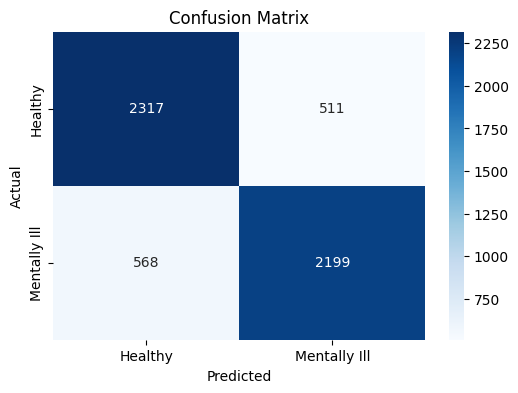

In [110]:
# Convert train and test text into TF-IDF features using only filtered words
vectorizer = TfidfVectorizer(vocabulary=[word for word, _ in filtered_words])
X_train = vectorizer.fit_transform(train_df["text"])
X_test = vectorizer.transform(test_df["text"])

# Train a logistic regression model
model = LogisticRegression(random_state=42)
model.fit(X_train, train_df["label"])

# Make predictions
y_pred = model.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(test_df["label"], y_pred)
precision = precision_score(test_df["label"], y_pred)
recall = recall_score(test_df["label"], y_pred)
f1 = f1_score(test_df["label"], y_pred)
print(f"Logistic Regression Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(test_df["label"], y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy", "Mentally Ill"], yticklabels=["Healthy", "Mentally Ill"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [111]:
# Classification report
print("Classification Report:")
print(classification_report(test_df["label"], y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81      2828
           1       0.81      0.79      0.80      2767

    accuracy                           0.81      5595
   macro avg       0.81      0.81      0.81      5595
weighted avg       0.81      0.81      0.81      5595



## 3.4 Model Testing & Observations  

For this test, we used a **random sample of 10,000 tweets** extracted from the dataset.  

Upon analyzing the results, we observed that while the words from our **dictionary are being correctly identified**, the **classification performance of our model is not optimal**.  


In [112]:
import pandas as pd

# Load the test dataset
df_test = pd.read_csv("data/test.csv")

# Select a random sample of 10,000 tweets
sample_df = df_test.sample(n=100000, random_state=42)

# Ensure the tweet data is in string format
sample_df["tweet"] = sample_df["tweet"].astype(str)

# Transform the sample data using the trained vectorizer
X_sample = vectorizer.transform(sample_df["tweet"])

# Apply the trained model to make predictions
predictions = model.predict(X_sample)

# Add the predictions to the DataFrame
sample_df["prediction"] = predictions

# Save the results to a CSV file if needed
sample_df.to_csv("data/predicted_tweets.csv", index=False)

print('Results saved at data/predicted_tweets.csv')
# Display the first results
# Filter only tweets where the prediction label is 1
filtered_df = sample_df[sample_df["prediction"] == 1]

# Show the first few rows of the filtered results
filtered_df




Results saved at data/predicted_tweets.csv


,index,tweet,prediction
26127,575595,"@dana_chosenart haha, thanks. But I don't thin...",1
142931,1268013,@ALauderdale Company and Sushi usually have th...,1
43195,1489378,"@cysticfibrosisM watching NCIS, but do feel a ...",1
3056,690148,@partycrasherxx i will never laugh for you any...,1
85840,474159,"going to bed, i feel so sick! Night xx",1
...,...,...,...
121422,1584846,"I'm waiting for basijis to come and kill me ,...",1
69584,1025661,Apparently Obama thinks Bush set aside princip...,1
1902,190965,So sleepy that I feel reluctant to show up at ...,1
63242,1599615,@brothrsaw The count would lead to shutter dea...,1



### ⚠ **3.4.1 Potential Reasons for Misclassification**
1. **Overfitting to Training Data**  
   - The model may have learned patterns too specific to the training set, reducing its generalization capability.

2. **Dictionary Simplicity**  
   - Currently, our **test dictionary** focuses **only on individual words**.  
   - Due to the **lower frequency of bi-grams**, they receive **lower scores** and are **not prominently featured** in the dictionary.  
   - **Solution:** Adjust scoring to create a **hybrid dictionary** combining **words and n-grams**.

3. **Social Media Spelling Variations**  
   - Users on social media frequently use **abbreviations, slang, and misspellings**.  
   - This can lead to **incorrect frequency measurements**, diminishing the relevance of certain words or bi-grams.  
   - **Solution:** Implement **text normalization techniques** to handle spelling variations more effectively.



### 3.4.2 **Possible Improves**
To improve classification performance, we propose:
- **Refining the dictionary** to better incorporate **n-grams**.
- **Applying spelling correction techniques** to reduce the impact of informal writing.
- **Fine-tuning the model to mitigate overfitting** and improve generalization.

    